# Initial Environment Setup + Imports

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Neccesary Imports**

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import argparse
import copy
import time
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  
else:
    device = torch.device('cpu')

print(f"Selected device: {device}")

Selected device: cuda


**Unzip file (RUN ONCE)**

In [ ]:
!unzip "/content/drive/MyDrive/prime_data/Prime_FULL.zip" -d "/content/"
!cp "/content/drive/MyDrive/prime_data/df_prime_train.csv" -d "/content/"
!cp "/content/drive/MyDrive/prime_data/df_prime_test.csv" -d "/content/"

# Load + Split Data

**Data image declaration**

In [ ]:
#Labels for Severity

LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

transform = transforms.Compose([
    transforms.CenterCrop(size=(300, 450)),
    transforms.Grayscale(),
    transforms.Resize(size=(100,100)),
    transforms.ToTensor(),
    normalize,
])

    
class OCTDataset(Dataset):
    def __init__(self, args, subset='train', transform=None,):
        if subset == 'train':
            self.annot = pd.read_csv(args.annot_train_prime, nrows=24064) #24064 #3584
        elif subset == 'test':
            self.annot = pd.read_csv(args.annot_test_prime, nrows=7936) #7936 #1536
            
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)] 
        # print(self.annot)
        self.root = os.path.expanduser(args.data_root)
        self.transform = transform
        # self.subset = subset
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values
        self._labels = self.annot['Severity_Label'].values
        assert len(self.path_list) == len(self._labels)
        # idx_each_class = [[] for i in range(self.nb_classes)]

    def __getitem__(self, index):
        img, target = Image.open(self.root+self.path_list[index]).convert("L"), self._labels[index]

        if self.transform is not None:
            img = self.transform(img)
        return img, target


    def __len__(self):
        return len(self._labels)         

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--annot_train_prime', type = str, default = 'df_prime_train.csv')
    parser.add_argument('--annot_test_prime', type = str, default = 'df_prime_test.csv')
    parser.add_argument('--data_root', type = str, default = '/content/')
    parser.add_argument('-f') #For ipynb support
    return parser.parse_args()



if __name__ == '__main__':
    args = parse_args()
    trainset = OCTDataset(args, 'train', transform=transform)
    testset = OCTDataset(args, 'test', transform=transform)




    print("Train Set initialized!")
    print("Size of trainset:", str(len(trainset)))
    print("Size of testset:", str(len(testset)))
    print("Torch Vector Size:", trainset[1][0].shape)

**Dataloader**

In [ ]:
batcheSize = 256

trainloader = DataLoader(trainset, batch_size= batcheSize, shuffle=True)
testloader =  DataLoader(testset, batch_size=batcheSize, shuffle=True)

print("Size of trainloader: " + str(len(trainloader)) + "\nSize of testloader:", len(testloader))
print(f"Number of images in trainloader: {len(trainloader) * batcheSize}")
print(f"Number of images in testloader: {len(testloader) * batcheSize}")


# Image Visualization

In [ ]:
# Define a dictionary to store the images for each class
class_images = {0: [], 1: [], 2: []}

# Iterate over the train loader and add the images to the dictionary for each class
for imgs, targets in trainloader:
    for i in range(imgs.size(0)):
        img = imgs[i]
        target = targets[i]
        class_images[target.item()].append(img)

    # Stop after 5 batches
    if len(class_images[0]) >= 5 and len(class_images[1]) >= 5 and len(class_images[2]) >= 5:
        break


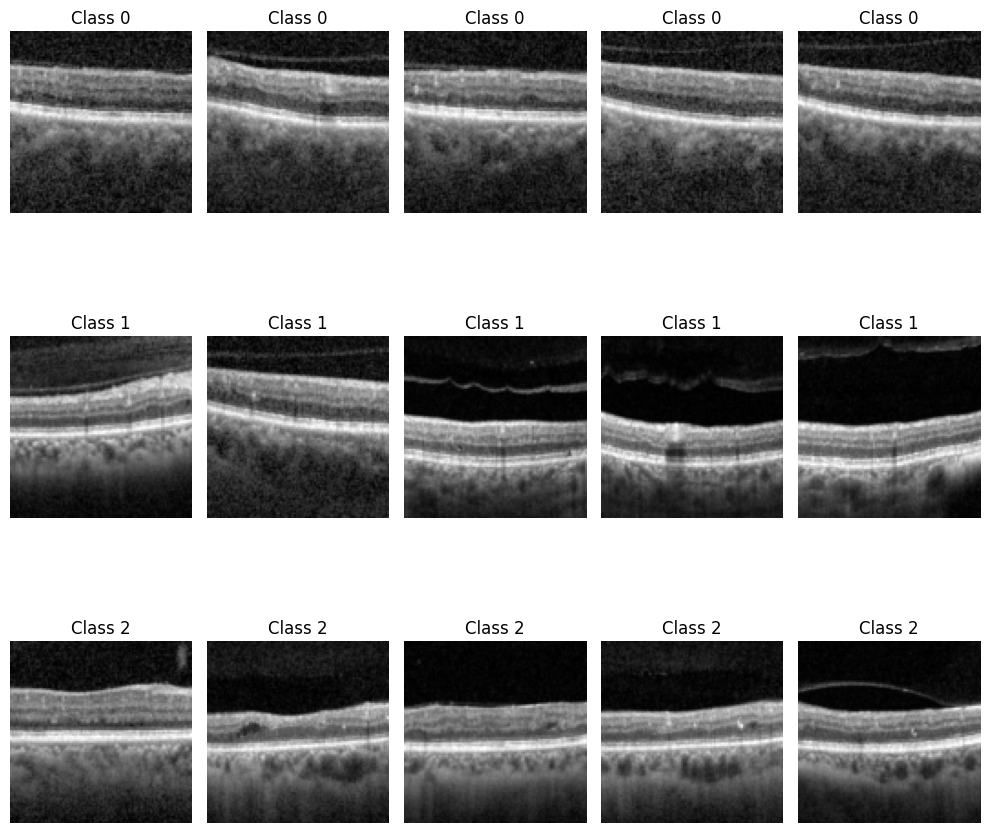

In [ ]:
# Plot 5 images for each class
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

for i in range(3):
    for j in range(5):
        img = class_images[i][j].permute(1, 2, 0).numpy()
        axs[i, j].imshow(img, cmap='gray')        
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Class {i}")

plt.tight_layout()
plt.show()

# Models and Training

**Untrained CNN**

CNN with 2 convolutional layers

In [ ]:
class CNN(torch.nn.Module):
  def __init__(self):
      super(CNN, self).__init__()
      self.convolution1 = nn.Conv2d(1, 16, 3, 1, 1, 1) #in 1, out 16, kernel 3, padding 1, stride 1, dilation 1
      self.convolution2 = nn.Conv2d(16, 32, 3, 1, 1, 1) #in 16, out 32, kernel 3, padding 1, stride 1, dilation 1
      self.relu = nn.ReLU()
      self.maxpool = nn.MaxPool2d(2)
      self.linear2 = nn.Linear(80000, 3) #180000 from 32 * 150/2 * 150/2

  def forward(self, x):
 
    conv1 = self.convolution1(x)
    relu1 = self.relu(conv1)

    conv2 = self.convolution2(relu1)
    relu2 = self.relu(conv2)

    max1 = self.maxpool(relu2).reshape(256, 80000)
    out = self.linear2(max1)


    return out

CNN with 2 convolutional layers with Dropout

In [ ]:
#Below is for two layers with dropout
class CNN2(torch.nn.Module):
  def __init__(self):
      super(CNN2, self).__init__()
      self.convolution1 = nn.Conv2d(1, 16, 3, 1, 1, 1) #in 1, out 16, kernel 3, padding 1, stride 1, dilation 1
      self.convolution2 = nn.Conv2d(16, 32, 3, 1, 1, 1) #in 16, out 32, kernel 3, padding 1, stride 1, dilation 1
      self.dropout1 = nn.Dropout(.2)
      self.relu = nn.ReLU()
      self.maxpool = nn.MaxPool2d(2)
      self.linear2 = nn.Linear(80000, 3) #180000 from 32 * 150/2 * 150/2

  def forward(self, x):
 
    conv1 = self.convolution1(x)
    relu1 = self.relu(conv1)
    drop1 = self.dropout1(relu1)
    conv2 = self.convolution2(drop1)
    relu2 = self.relu(conv2)

    max1 = self.maxpool(relu2).reshape(256, 80000)
    out = self.linear2(max1)


    return out

CNN with 3 convolutional layers

In [ ]:
class CNN3(torch.nn.Module):
  def __init__(self):
    super(CNN3, self).__init__()
    self.convolution1 = nn.Conv2d(1, 16, 3, 1, 1) #in 1, out 16, kernel 3, padding 1, stride 1
    self.convolution2 = nn.Conv2d(16, 32, 3, 1, 1) #in 16, out 32, kernel 3, padding 1, stride 1
    self.convolution3 = nn.Conv2d(32, 64, 3, 1, 1) #in 32, out 64, kernel 3, padding 1, stride 1
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(2)
    self.linear = nn.Linear(160000, 3)


  def forward(self, x):
    conv1 = self.convolution1(x)
    relu1 = self.relu(conv1)
    
    conv2 = self.convolution2(relu1)
    relu2 = self.relu(conv2)

    conv3 = self.convolution3(relu2)
    relu3 = self.relu(conv3)
    
    max1 = self.maxpool(relu3).reshape(256, 160000)
    out = self.linear(max1)

    return out


Training the model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# perform training 
lr = 0.01   #2.5e-4
epochs = 10

# initliaze the network
net = CNN()
net = net.to('cuda')

loss = nn.CrossEntropyLoss() #Use cross entropy
optimizer = torch.optim.Adam(net.parameters(), lr) #use Adam to combine Adagrad and Momentum

total_accuracy = pd.DataFrame(columns=["training accuracy", "testing (validation) accuracy"])
total_loss = pd.DataFrame(columns=["training loss", "testing (validation) loss"])
train_predictions = []
train_labels = []
test_predictions = []
test_labels = []

for epoch in range(epochs):
    print("epoch: ", epoch)
    print("-"*10)

    # training (train data)
    print("TRAINING")
    net.train()

    epoch_train_loss = 0.0
    epoch_train_correct = 0.0;
    epoch_test_loss = 0.0;
    epoch_test_correct = 0.0;
      
    for (i, (x_train,y_train)) in enumerate(trainloader):
        print(i)
        x_train, y_train = x_train.cuda(), y_train.cuda()

        optimizer.zero_grad()

        train_temp_pred = net(x_train)
        train_temp_loss = loss(train_temp_pred,y_train)

        train_temp_loss.backward()
        optimizer.step()

        epoch_train_loss += train_temp_loss
        epoch_train_correct += (train_temp_pred.argmax(1) == y_train).type(torch.float).sum().item()
      
    print('TESTING')
    with torch.no_grad():
        net.eval() # evaluation mode
        for (i, (x_test,y_test)) in enumerate(testloader):
            print(i)
            x_test, y_test = x_test.cuda(), y_test.cuda()

            test_temp_pred = net(x_test)
            test_temp_loss = loss(test_temp_pred,y_test)

            epoch_test_loss += test_temp_loss
            epoch_test_correct += (test_temp_pred.argmax(1) == y_test).type(torch.float).sum().item()

     # save epoch accuracy/loss average for each epoch and all predictions
    total_accuracy.loc[len(total_accuracy.index)] = [epoch_train_correct/(len(trainloader)*batcheSize), epoch_test_correct/(len(testloader)*batcheSize)]
    total_loss.loc[len(total_loss.index)] = [float(epoch_train_loss/(len(trainloader)*batcheSize)), float(epoch_test_loss/(len(testloader)*batcheSize))]
    train_predictions.append(train_temp_pred.argmax(1))
    train_labels.append(y_train)
    test_predictions.append(test_temp_pred.argmax(1))
    test_labels.append(y_test)

    # Save the model
    torch.save(net.state_dict(), f'nn_v4_{epoch}.pth')

# Graphing Plots

Imports for Graphics

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

Plotting Accuracy Curve for Training and Testing Dataset

In [ ]:
plt.plot(range(0,num_epochs), total_accuracy.iloc[:,0], label='Training Accuracy')
plt.plot(range(0,num_epochs), total_accuracy.iloc[:,1], label='Testing (Validation) Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

Plotting Loss Curve for Training and Testing Dataset

In [ ]:
num_epochs = 10
plt.plot(range(0,num_epochs), total_loss.iloc[:,0], label='Training Loss')
plt.plot(range(0,num_epochs), total_loss.iloc[:,1], label='Testing (Validation) Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

Extracting Last Epoch

In [ ]:
test_pred_labels = pd.DataFrame(columns=['prediction','true label'])

for i in range(len(test_predictions)):
  print(i)
  for j in range(len(test_predictions[0])):
    test_pred_labels.loc[len(test_pred_labels.index)] = [int(test_predictions[i][j]), int(test_labels[i][j])]

test_last_epoch = test_pred_labels.iloc[-batcheSize:].reset_index(drop=True)

train_pred_labels = pd.DataFrame(columns=['prediction','true label'])

for i in range(len(train_predictions)):
  print(i)
  for j in range(len(train_predictions[0])):
    train_pred_labels.loc[len(train_pred_labels.index)] = [int(train_predictions[i][j]), int(train_labels[i][j])]

train_last_epoch = train_pred_labels.iloc[-batcheSize:].reset_index(drop=True)

Saving labels, accuracy, and loss to CSV

In [ ]:
test_pred_labels.to_csv("CNNFromScratch_10Lr0.01tepochs_test_predtrue_labels.csv",index=False)
train_pred_labels.to_csv("CNNFromScratch_10Lr0.01epochs_train_predtrue_labels.csv",index=False)
total_accuracy.to_csv("CNNFromScratch_10epochsLr0.01_traintest_accuracy.csv",index=False)
total_loss.to_csv("CNNFromScratch_10epochsLr0.01_traintest_loss.csv",index=False)

Plotting Multiclass ROC Curve

In [ ]:
def plot_multiclass_roc_curve(test_labels, predicted_labels, n_classes):
    # Binarize the labels
    test_labels_binarized = label_binarize(test_labels, classes=np.arange(n_classes))
    predicted_labels_binarized = label_binarize(predicted_labels, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate ROC curve and ROC-AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], predicted_labels_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot the ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

test_last_epoch = test_pred_labels.iloc[-batcheSize:].reset_index(drop=True)
plot_multiclass_roc_curve(test_last_epoch.iloc[:,1],test_last_epoch.iloc[:,0],3)

Confusion Matrix

In [ ]:
def plot_confusion_matrix(test_labels, predicted_labels):
    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

plot_confusion_matrix(test_last_epoch.iloc[:,1],test_last_epoch.iloc[:,0])
# plot_confusion_matrix(test_labels, predicted_labels)


Classification Report and Balanced Accuracy

In [ ]:
# compute the balanced accuracy score
balanced_accuracy = balanced_accuracy_score(test_last_epoch.iloc[:,1],test_last_epoch.iloc[:,0])
print("Balanced accuracy score:", balanced_accuracy)

In [ ]:
# get general metrics
print(classification_report(test_last_epoch.iloc[:,1],test_last_epoch.iloc[:,0]))

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

